In [2]:
using Plots, AbstractTrees

# Lab 08 - Reverse Mode Differentiation

<img src="gd-path.gif" width="900" align="center">

In the lecture you have seen how to implement *forward-mode* automatic
differentiation (AD). Assume you want to find the derivative $\frac{df}{dx}$ of
the function $f:\mathbb R^2 \rightarrow \mathbb R$

```julia
f(x,y) = x*y + sin(x)
```

If we have rules for `*`, `+`, and `sin` we could simply *seed* the function with
`Dual(x,one(x))` and read out the derivative $\frac{df}{dx}$ from the `Dual` that is returned
by `f`. If we are also interested in the derivative $\frac{df}{dy}$ we will have
to run `f` again, this time seeding the second argument with `Dual(y,one(y))`.
Hence, we have to evaluate `f` *twice* if we want derivatives w.r.t to both its
arguments which means that forward differentiation scales as $O(N)$ where $N$ is
the number of inputs to `f`.


```julia
dfdx = f(Dual(x,one(x)), Dual(y,zero(y)))
dfdy = f(Dual(x,zero(x)), Dual(y,one(y)))
```

*Reverse-mode* AD can compute gradients of functions with many inputs and one
output in one go. This is great because very often we want to optimize loss
functions which are exactly that: Functions with many input variables and one
loss output.

## Reverse Mode AD

With functions $f:\mathbb R^N\rightarrow\mathbb R^M$ and $g:\mathbb
R^L\rightarrow \mathbb R^N$ with an input vector $x$ we can define the
composition of $f$ and $g$ as

\begin{equation}
z = (f \circ g)(x), \qquad \text{where} \qquad y=g(x), \qquad z = f(y).
\end{equation}

The multivariate chainrule reads

\begin{equation}
\left.\frac{\partial z_i}{\partial x_j}\right|_{x} =
    \sum_{k=1}^N \left.\frac{\partial z_i}{\partial y_k}\right|_{y}
                 \left.\frac{\partial y_k}{\partial x_i}\right|_{x}
\end{equation}

If you want to read about where this comes from you can check
[here](https://math.stackexchange.com/questions/3785018/intuitive-proof-of-the-multivariable-chain-rule)
or [here](https://people.math.harvard.edu/~shlomo/docs/Advanced_Calculus.pdf).
It is essentially one row of the *Jacobian matrix* $J$.
Note that in order to compute the derivative we always have to know the input
to the respective function, because we can only compute the derivative *at a specific point*
(denoted by the $|_x$ $_{}$ notation).  For our example

\begin{equation}
z = f(x,y) = xy + \sin(x)
\end{equation}

with the sub-functions $g(x,y)=xy$ and $h(x)=\sin(x)$ we get

\begin{equation}
\left.{\frac {df}{dx}}\right|_{x,y}
    = \left.{\frac {df}{dg}}\right|_{g(x,y)}\cdot \left.{\frac {dg}{dx}}\right|_{x,y}
    + \left.{\frac {df}{dh}}\right|_{h(x)}\cdot \left.{\frac {dh}{dx}}\right|_{x}
    = 1 \cdot y |_{y} + 1\cdot\cos(x)|_{x}.
\end{equation}

You can see that, in order to implement reverse-mode AD we have to trace and
remember all inputs to our intermediate functions during the forward pass such
that we can compute their gradients during the backward pass. The simplest way
of doing this is by dynamically building a computation graph which tracks how
each input variable affects its output variables. The graph below represents
the computation of our function `f`.
```julia
z = x*y + sin(x)

# as a Wengert list   # Partial derivatives
a = x*y               # da/dx = y;     da/dy = x
b = sin(x)            # db/dx = cos(x)
z = a + b             # dz/da = 1;     dz/db = 1
```

<img src="graph.png" align="center">

In the graph you can see that the variable `x` can directly affect `b` and `a`.
Hence, `x` has two children `a` and `b`.  During the forward pass we build the
graph, keeping track of which input affects which output. Additionally we
include the corresponding local derivatives (which we can already compute).
To implement a dynamically built graph we can introduce a new number type
`TrackedReal` which has three fields:
* `data` contains the value of this node in the computation graph as obtained
  in the forward pass.
* `grad` is initialized to `nothing` and will later hold the accumulated gradients (the sum in the multivariate chain rule)
* `children` is a `Dict` that keeps track which output variables are affected
  by the current node and also stores the corresponding local derivatives
  $\frac{\partial f}{\partial g_k}$.


In [3]:
# TrackedReal
mutable struct TrackedReal{T<:Real}
    data::T
    grad::Union{Nothing, T}
    children::Dict
    name::String
end

# track()
track(x::Real, name="") = TrackedReal(x, nothing, Dict(), name)

# show(io, x)
function Base.show(io::IO, x::TrackedReal)
    t = isempty(x.name) ? "(tracked)" : "(tracked $(x.name))"
    print(io, "$(x.data) $t")
end


#### Solution

In [ ]:
mutable struct TrackedReal{T<:Real}
    data::T
    grad::Union{Nothing,T}
    children::Dict
    # this field is only need for printing the graph. you can safely remove it.
    name::String
end

track(x::Real,name="") = TrackedReal(x,nothing,Dict(),name)

function Base.show(io::IO, x::TrackedReal)
    t = isempty(x.name) ? "(tracked)" : "(tracked $(x.name))"
    print(io, "$(x.data) $t")
end

###
The backward pass is nothing more than the application of the chainrule. To
compute the derivative. Assuming we know how to compute the *local derivatives*
$\frac{\partial f}{\partial g_k}$ for simple functions
such as `+`, `*`, and `sin`, we can write a simple function that implements
the gradient accumulation from above via the chainrule
        
\begin{equation}
\left.\frac{\partial f}{\partial x_i}\right|_{x} =
    \sum_{k=1}^N \left.\frac{\partial f}{\partial g_k}\right|_{g(x)}
                 \left.\frac{\partial g_k}{\partial x_i}\right|_{x}.
\end{equation}
        
We just have to loop over all children, collect the local derivatives, and
recurse:

In [6]:
# accum! function
function accum!(x::TrackedReal)
    if isnothing(x.grad) 
        x.grad = sum(w*accum!(v) for (v, w) in x.children) 
    end
    x.grad
end

accum! (generic function with 1 method)

#### Solution

In [ ]:
function accum!(x::TrackedReal)
    if isnothing(x.grad)
        x.grad = sum(w*accum!(v) for (v,w) in x.children)
    end
    x.grad
end

###
where `w` corresponds to $\frac{\partial f}{\partial g_k}$ and `accum!(v)` corresponds
to $\frac{\partial g_k}{\partial x_i}$. At this point we have already implemented
the core functionality of our first reverse-mode AD! The only thing left to do
is implement the reverse rules for basic functions.  Via recursion the
chainrule is applied until we arrive at the final output `z`.  This final
output has to be seeded (just like with forward-mode) with $\frac{\partial
z}{\partial z}=1$.


### Writing Reverse Rules

Lets start by overloading the three functions `+`, `*`, and `sin` that we need
to build our computation graph. First, we have to track the forward computation
and then we *register* the output `z` as a child of its inputs by using `z`
as a key in the dictionary of children. The corresponding value holds the 
derivatives, in the case of multiplication case we simply have
\begin{equation}
z = a \cdot b
\end{equation}
for which the derivatives are
\begin{equation}
\frac{\partial z}{\partial a}=b, \qquad
\frac{\partial z}{\partial b}=a.
\end{equation}
Knowing the derivatives of `*` at a given point we can write our reverse rule

In [14]:
# multiplication
function Base.:*(a::TrackedReal, b::TrackedReal)
    z = track(a.data*b.data, "*")
    a.children[z] = b.data
    b.children[z] = a.data
    return z
end


#### Solution

In [ ]:
function Base.:*(a::TrackedReal, b::TrackedReal)
    z = track(a.data * b.data, "*")
    a.children[z] = b.data  # dz/da=b
    b.children[z] = a.data  # dz/db=a
    z
end

###
Creating two tracked numbers and adding them results in


In [9]:
x = track(2.0)

2.0 (tracked)

In [10]:
y = track(3.0)

3.0 (tracked)

In [11]:
z = x*y

6.0 (tracked)

In [12]:
x.children

Dict{Any, Any} with 1 entry:
  6.0 (tracked) => 3.0

In [13]:
y.children

Dict{Any, Any} with 1 entry:
  6.0 (tracked) => 2.0

### Exercise 1

Implement the two remaining rules for `+` and `sin` by overloading the
appropriate methods like we did for `*`. First you have to compute the tracked
forward pass, and then register the local derivatives in the children of your
input variables.  Remember to return the tracked result of the forward pass in
the end.

In [17]:
# addition
function Base.:+(a::TrackedReal{T}, b::TrackedReal{T}) where T
    z = track(a.data + b.data,"+")
    a.children[z] = one(T)
    b.children[z] = one(T)
    z
end

# sin
function Base.sin(x::TrackedReal)
    z = track(sin(x.data), "sin")
    x.children[z] = cos(x.data)
    z
end


#### Solution

In [ ]:
function Base.:+(a::TrackedReal{T}, b::TrackedReal{T}) where T
    z = track(a.data + b.data, "+")
    a.children[z] = one(T)
    b.children[z] = one(T)
    z
end

function Base.sin(x::TrackedReal)
    z = track(sin(x.data), "sin")
    x.children[z] = cos(x.data)
    z
end

## Forward & Backward Pass

To visualize that with reverse-mode AD we really do save computation we can
visualize the computation graph at different stages. We start with the forward
pass and keep observing `x`

#### Overload AbstractTrees (to get nice printout)


"x data: 2.0 grad: nothing"\
└─ "* data: 6.0 grad: nothing"

1) children
2) nodevalue

In [29]:
function AbstractTrees.printnode(io::IO, x::TrackedReal)
    print(io, "$(x.name) data: $(round(x.data, digits=2)) grad: $(x.grad)")
end

AbstractTrees.children(x::TrackedReal) = x.children |> keys |> collect

#### Solution

In [ ]:
function AbstractTrees.children(t::TrackedReal)
    keys(t.children)
end

# Two options for printing
function AbstractTrees.nodevalue(t::TrackedReal)
    "$(t.name) data: $(round(t.data,digits=2)) grad: $(t.grad)"
end 
function AbstractTrees.printnode(io::IO,v::TrackedReal)
    print(io,"$(v.name) data: $(round(v.data,digits=2)) grad: $(v.grad)")
end

#### 

In [23]:
x = track(2.0, "x")

2.0 (tracked x)

In [24]:
y = track(3.0, "y")

3.0 (tracked y)

In [25]:
a = x*y

6.0 (tracked *)

In [26]:
print_tree(x)

x data: 2.0 grad: nothing
└─ * data: 6.0 grad: nothing


We can see that we `x` now has one child `a` which has the value `2.0*3.0==6.0`. All the
gradients are still `nothing`. Computing another value that depends on `x`
will add another child.

In [27]:
b = sin(x)

0.9092974268256817 (tracked sin)

In [30]:
print_tree(x)

x data: 2.0 grad: nothing
├─ * data: 6.0 grad: nothing
└─ sin data: 0.91 grad: nothing


In the final step we compute `z` which does not mutate the children of `x`
because it does not depend directly on it. The result `z` is added as a child
to both `a` and `b`.

In [31]:
z = a + b

6.909297426825682 (tracked +)

In [32]:
print_tree(x)

x data: 2.0 grad: nothing
├─ * data: 6.0 grad: nothing
│  └─ + data: 6.91 grad: nothing
└─ sin data: 0.91 grad: nothing
   └─ + data: 6.91 grad: nothing


For the backward pass we have to seed the initial gradient value of `z` and
call `accum!` on the variable that we are interested in.

In [33]:
z.grad = 1

1

In [34]:
dx = accum!(x)

2.5838531634528574

In [36]:
dx ≈ y.data + cos(x.data)

true

By accumulating the gradients for `x`, the gradients in the sub-tree connected
to `x` will be evaluated. The parts of the tree that are only connected to `y`
stay untouched.

In [37]:
print_tree(x)

x data: 2.0 grad: 2.5838531634528574
├─ * data: 6.0 grad: 1.0
│  └─ + data: 6.91 grad: 1.0
└─ sin data: 0.91 grad: 1.0
   └─ + data: 6.91 grad: 1.0


In [38]:
print_tree(y)

y data: 3.0 grad: nothing
└─ * data: 6.0 grad: 1.0
   └─ + data: 6.91 grad: 1.0


If we now accumulate the gradients over `y` we re-use the gradients that are already
computed. In larger computations this will save us *a lot* of effort!

!!! info : 
    This also means that we have to re-build the graph for every new set of inputs!


##  Optimizing 2D Functions


### Exercise 2

Implement a function `gradient(f, args::Real...)` which takes a function `f`
and its corresponding arguments (as `Real` numbers) and outputs the corresponding
gradients

In [40]:
function gradient(f, args::Real...)
    ts = track.(args)
    y = f(ts...)
    y.grad = 1
    accum!.(ts)
end

gradient (generic function with 1 method)

#### Solution

In [ ]:
function gradient(f, args::Real...)
    ts = track.(args)
    y  = f(ts...)
    y.grad = 1.0
    accum!.(ts)
end

#

In [41]:
f(x,y) = x*y + sin(x)

f (generic function with 1 method)

In [42]:
gradient(f, 2.0, 3.0)

(2.5838531634528574, 2.0)

As an example we can find a local minimum of the function `g` (slightly
modified to show you that we can now actually do *automatic* differentiation).

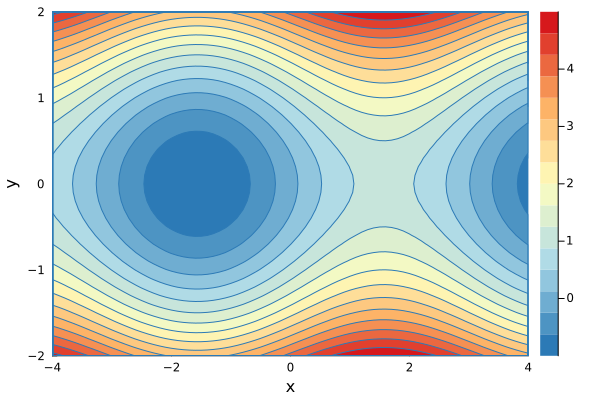

In [43]:
g(x,y) = y*y + sin(x)

color_scheme = cgrad(:RdYlBu_5, rev=true)
contour(-4:0.1:4, -2:0.1:2, g, fill=true, c=color_scheme, xlabel="x", ylabel="y")

We can find a local minimum of $g$ by starting at an initial point $(x_0,y_0)$
and taking small steps in the opposite direction of the gradient

\begin{align}
x_{i+1} &= x_i - \lambda \frac{\partial f}{\partial x_i} \\
y_{i+1} &= y_i - \lambda \frac{\partial f}{\partial y_i},
\end{align}

where $\lambda$ is the learning rate that has to be tuned manually.

### Exercise 3
Implement a function `descend` performs one step of Gradient Descent (GD) on a
function `f` with an arbitrary number of inputs. For GD you also have to
specify the learning rate $\lambda$ so the function signature should look like
this 
```julia
descend(f::Function, λ::Real, args::Real...)
```

In [45]:
function descend(f::Function, λ::Real, args::Real...)
    Δargs = gradient(f, args...)
    args .- λ .* Δargs
end

descend (generic function with 1 method)

#### Solution

In [ ]:
function descend(f::Function, λ::Real, args::Real...)
    Δargs = gradient(f, args...)
    args .- λ .* Δargs
end

#
Running one `descend` step should result in two new inputs with a smaller output


In [46]:
g(1.0,1.0)

1.8414709848078965

In [47]:
(x,y) = descend(g, 0.2, 1.0, 1.0)

(0.891939538826372, 0.8)

In [48]:
g(x,y)

1.4182910542267546

You can `minimize` a `g` starting from an initial value. Below is a code
snippet that performs a number of `descend` steps on two different initial
points and creates an animation of each step of the GD algorithm.

┌ Info: Saved animation to /Users/ghosty/AI_Center/Scientific-Programing-in-Julia/lab8/tmp.gif
└ @ Plots /Users/ghosty/.julia/packages/Plots/YbrTT/src/animation.jl:149


Plots.AnimatedGif("/Users/ghosty/AI_Center/Scientific-Programing-in-Julia/lab8/tmp.gif")
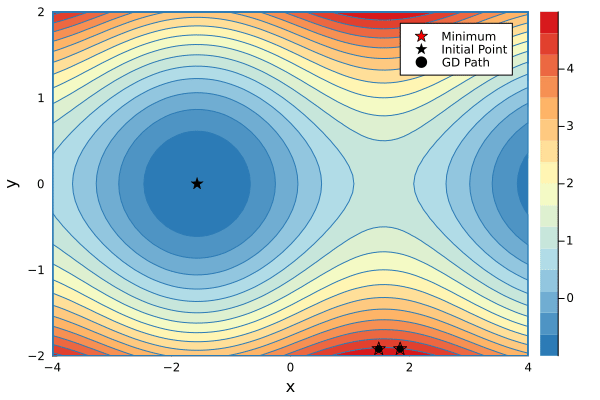

In [53]:
function minimize(f::Function, args::T...; niters=20, λ=0.01) where T<:Real
    paths = ntuple(_->Vector{T}(undef,niters), length(args))
    for i in 1:niters
        args = descend(f, λ, args...)
        #@info f(args...)
        for j in 1:length(args)
            paths[j][i] = args[j]
        end
    end
    paths
end

xs1, ys1 = minimize(g, 1.5, -2.4, λ=0.2, niters=34)#1.5
xs2, ys2 = minimize(g, 1.8, -2.4, λ=0.2, niters=16)

p1 = contour(-4:0.1:4, -2:0.1:2, g, fill=true, c=color_scheme, xlabel="x", ylabel="y")
scatter!(p1, [xs1[1]], [ys1[1]], mc=:red, marker=:star, ms=7, label="Minimum")
scatter!(p1, [xs2[1]], [ys2[1]], mc=:red, marker=:star, ms=7, label=false)
scatter!(p1, [-π/2], [0], mc=:black, marker=:star, ms=7, label="Initial Point")
scatter!(p1, xs1[1:1], ys1[1:1], mc=:black, label="GD Path", xlims=(-4,4), ylims=(-2,2))

@gif for i in 1:max(length(xs1), length(xs2))
    if i <= length(xs1)
        scatter!(p1, xs1[1:i], ys1[1:i], mc=:black, lw=3, xlims=(-4,4), ylims=(-2,2), label=false)
    end
    if i <= length(xs2)
        scatter!(p1, xs2[1:i], ys2[1:i], mc=:black, lw=3, label=false)
    end
    p1
end

At this point you can move to the [homework](@ref hw08) of this lab.  If you want to
know how to generalize this simple reverse AD to work with functions that
operate on `Array`s, feel free to continue with the remaining **volutary part
of the lab**.

## Naively Vectorized Reverse AD

A naive solution to use our `TrackedReal` number type to differentiate
functions that operate on vectors is to just use `Array{<:TrackedReal}`.
Unfortunately, this means that we have to replace the fast BLAS matrix
operations with our own matrix multiplication methods that know how to deal
with `TrackedReal`s.  This results in large performance hits and your task
during the rest of the lab is to implement a smarter solution to this problem.

In [ ]:
using LinearAlgebra

Base.zero(::TrackedReal{T}) where T = TrackedReal(zero(T))
LinearAlgebra.adjoint(x::TrackedReal) = x
track(x::Array) = track.(x)
accum!(xs::Array{<:TrackedReal}) = accum!.(xs)

const VecTracked = AbstractVector{<:TrackedReal}
const MatTracked = AbstractMatrix{<:TrackedReal}

LinearAlgebra.dot(xs::VecTracked, ys::VecTracked) = mapreduce(*, +, xs, ys)
Base.:*(X::MatTracked, y::VecTracked) = map(x->dot(x,y), eachrow(X))
Base.:*(X::MatTracked, Y::MatTracked) = mapreduce(y->X*y, hcat, eachcol(Y))
Base.sum(xs::AbstractArray{<:TrackedReal}) = reduce(+,xs)

function reset!(x::TrackedReal)
    x.grad = nothing
    reset!.(keys(x.children))
    x.children = Dict()
end

X = rand(2,3)
Y = rand(3,2)

function run()
    Xv = track(X)
    Yv = track(Y)
    z = sum(Xv * Yv)
    z.grad = 1.0
    accum!(Yv)
end

In [ ]:
using BenchmarkTools
@benchmark run()

## Reverse AD with `TrackedArray`s

To make use of the much faster BLAS methods we have to implement a custom array
type which will offload the heavy matrix multiplications to the normal matrix
methods.  Start with a **fresh REPL** and possibly a **new file** that only
contains the definition of our `TrackedReal`:

```julia
mutable struct TrackedReal{T<:Real}
    data::T
    grad::Union{Nothing,T}
    children::Dict
end

track(x::Real) = TrackedReal(x, nothing, Dict())
```

### Exercise 4
Define a new `TrackedArray` type which subtypes and `AbstractArray{T,N}` and contains
the three fields: `data`, `grad`, and `children`. Which type should `grad` have?

Additionally define `track(x::Array)`, and forward `size`, `length`, and `eltype`
to `x.data` (maybe via metaprogrammming? ;).

#### Solution

In [ ]:
mutable struct TrackedArray{T,N,A<:AbstractArray{T,N}} <: AbstractArray{T,N}
    data::A
    grad::Union{Nothing,A}
    children::Dict
end

track(x::Array) = TrackedArray(x, nothing, Dict())
track(x::Union{TrackedArray,TrackedReal}) = x

for f in [:size, :length, :eltype]
	eval(:(Base.$(f)(x::TrackedArray, args...) = $(f)(x.data, args...)))
end

# only needed for hashing in the children dict...
Base.getindex(x::TrackedArray, args...) = getindex(x.data,args...)

# pretty print TrackedArray
Base.show(io::IO, x::TrackedArray) = print(io, "Tracked $(x.data)")
Base.print_array(io::IO, x::TrackedArray) = Base.print_array(io, x.data)

# 
Creating a `TrackedArray` should work like this:

In [ ]:
track(rand(2,2))

In [ ]:
function accum!(x::Union{TrackedReal,TrackedArray})
    if isnothing(x.grad)
        x.grad = sum(λ(accum!(Δ)) for (Δ,λ) in x.children)
    end
    x.grad
end

In [ ]:
methods(accum!)

To implement the first rule for `*` i.e. matrix multiplication we would first
have to derive it. In the case of general matrix multiplication (which is a function
$(R^{N\times M}, R^{M\times L}) \rightarrow R^{N\times L}$) we are not dealing
with simple derivatives anymore, but with a so-called *pullback* which takes a
*wobble* in the output space $R^{N\times L}$  and returns a *wiggle* in the input space
(either $R^{N\times M}$ or $R^{M\times L}$).

Luckily
[`ChainRules.jl`](https://juliadiff.org/ChainRulesCore.jl/dev/arrays.html) has
a nice guide on how to derive array rules, so we will only state the solution
for the reverse rule such that you can implement it. They read:

\begin{equation}
\bar A = \bar\Omega B^T, \qquad \bar B = A^T\bar\Omega
\end{equation}

Where $\bar\Omega$ is the given output *wobble*, which in the simplest case can
be the seeded value of the final node. The crucial problem to note here is that
the two rules rely in $\bar\Omega$ being multiplied *from different sides*.
This information would be lost if would just store $B^T$ as the pullback for
$A$.  Hence we will store our pullbacks as closures:

```julia
Ω̄ -> Ω̄  * B'
Ω̄ -> A' * Ω̄
```

### Exercise 5
Define the pullback for matrix multiplication i.e. `Base.:*(A::TrackedArray,B::TrackedArray)`
by computing the primal and storing the partials as closures.

#### Solution

In [ ]:
function Base.:*(X::TrackedArray, Y::TrackedArray)
    Z = track(X.data * Y.data)
    X.children[Z] = Δ -> Δ * Y.data'
    Y.children[Z] = Δ -> X.data' * Δ
    Z
end

In [ ]:
X = track(rand(2,3))

#


In [ ]:
X = rand(2,3) |> track

In [ ]:
Y = rand(3,2) |> track

In [ ]:
Z = X*Y

In [ ]:
X.children[Z]

In [ ]:
f_ = X.children[Z]

In [ ]:
Ω̄ = ones(size(Z)...)

In [ ]:
f_(Ω̄)

In [ ]:
Ω̄*Y.data'

### Exercise 6
Implement rules for `sum`, `+`, `-`, and  `abs2`.

#### Solution

In [ ]:
function Base.sum(x::TrackedArray)
    z = track(sum(x.data))
    x.children[z] = Δ -> Δ*ones(eltype(x), size(x)...)
    z
end

function Base.:+(X::TrackedArray, Y::TrackedArray)
    Z = track(X.data + Y.data)
    X.children[Z] = Δ -> Δ
    Y.children[Z] = Δ -> Δ
    Z
end

function Base.:-(X::TrackedArray, Y::TrackedArray)
    Z = track(X.data - Y.data)
    X.children[Z] = Δ -> Δ
    Y.children[Z] = Δ -> -Δ
    Z
end

function Base.abs2(x::TrackedArray)
    y = track(abs2.(x.data))
    x.children[y] = Δ -> Δ .* 2x.data
    y
end


# 


In [ ]:
X = rand(2,3)
Y = rand(3,2)
function run()
    Xv = track(X)
    Yv = track(Y)
    z = sum(Xv * Yv)
    z.grad = 1.0
    accum!(Yv)
end

In [ ]:
@benchmark run()

####

Even for this tiny example we are already 10 times faster than with the naively
vectorized approach!

In order to implement a full neural network we need two more rules. One for
the non-linearity and one for concatentation of individual training points to
a batch.

In [ ]:
σ(x::Real) = 1/(1+exp(-x))
σ(x::AbstractArray) = σ.(x)
function σ(x::TrackedArray)
    z = track(σ(x.data))
    d = z.data
    x.children[z] = Δ -> Δ .* d .* (1 .- d)
    z
end

function Base.hcat(xs::TrackedArray...)
    y  = track(hcat(data.(xs)...))
    stops  = cumsum([size(x,2) for x in xs])
    starts = vcat([1], stops[1:end-1] .+ 1)
    for (start,stop,x) in zip(starts,stops,xs)
        x.children[y] = function (Δ)
            δ = if ndims(x) == 1
                Δ[:,start]
            else
                ds = map(_ -> :, size(x)) |> Base.tail |> Base.tail
                Δ[:, start:stop, ds...]
            end
            δ
        end
    end
    y
end

You can see a full implementation of our tracing based AD [here](https://github.com/JuliaTeachingCTU/Scientific-Programming-in-Julia/blob/master/src/ReverseDiff.jl)
and a simple implementation of a Neural Network that can learn an approximation
to the function `g` [here](https://github.com/JuliaTeachingCTU/Scientific-Programming-in-Julia/blob/master/docs/src/lecture_08/reverse-nn.jl). Running the latter script will produce an animation
that shows how the network is learning.

<img src="anim.gif" width="1300" align="center">